In [1]:
import logging
import matplotlib.pyplot as plt
import tqdm

import numpy as np
import jax.numpy as jnp

from extravaganza.controllers import Controller
from extravaganza.stats import Stats
from extravaganza.utils import set_seed
from extravaganza.experiments import Experiment

class PID(Controller):
    def __init__(self, 
                 control_dim: int, 
                 setpoint: jnp.ndarray,
                 obs_mask: jnp.ndarray,
                 Kp: jnp.ndarray = None, 
                 Ki: jnp.ndarray = None, 
                 Kd: jnp.ndarray = None, 
                 stats: Stats = None):
        
        obs_dim = int(sum(obs_mask))
        if isinstance(setpoint, float): setpoint = jnp.array([setpoint])
        assert setpoint.shape == (obs_dim,)
        
        self.Kp, self.Ki, self.Kd = map(lambda t: jnp.array(t).reshape(control_dim, obs_dim) if t is not None else jnp.zeros((control_dim, obs_dim)), 
                                        [Kp, Ki, Kd])
        self.obs_dim = obs_dim
        self.control_dim = control_dim
        self.setpoint = setpoint
        self.obs_idxs = jnp.where(jnp.array(obs_mask) == 1)[0]
        
        self.p = jnp.zeros(self.obs_dim)
        self.i = jnp.zeros(self.obs_dim)

        self.t = 0
        if stats is None:
            logging.debug('({}): no `Stats` object provided, so a new one will be made.'.format(get_classname(self)))
            stats = Stats()
        self.stats = stats
        if obs_dim == 1:
            self.stats.register('Kp', float, plottable=True)
            self.stats.register('Ki', float, plottable=True)
            self.stats.register('Kd', float, plottable=True)
            self.stats.register('P', float, plottable=True)
            self.stats.register('I', float, plottable=True)
            self.stats.register('D', float, plottable=True)
        pass
    
    def reset(self, seed: int = None):
        set_seed(seed)  # for reproducibility

        self.p = jnp.zeros(self.obs_dim)
        self.i = jnp.zeros(self.obs_dim)
        pass
    
    def get_control(self, 
                    cost: float, 
                    state: jnp.ndarray) -> jnp.ndarray:
        state = jnp.take(state, self.obs_idxs)
        assert state.shape == (self.obs_dim,), state.shape
        
        error = state - self.setpoint
        
        p, i, d = self.p, self.i, error - self.p
        control = self.Kp @ p + self.Ki @ i + self.Kd @ d
        
        self.p = error
        self.i += error
        self.t += 1
        
        if self.obs_dim == 1:
            self.stats.update('Kp', self.Kp.item(), t=self.t)
            self.stats.update('Ki', self.Ki.item(), t=self.t)
            self.stats.update('Kd', self.Kd.item(), t=self.t)
            self.stats.update('P', p.item(), t=self.t)
            self.stats.update('I', i.item(), t=self.t)
            self.stats.update('D', d.item(), t=self.t)
        return control

In [72]:
from typing import Callable, Tuple
from extravaganza.dynamical_systems import DynamicalSystem, Gym

class PIDGym(DynamicalSystem):
    def __init__(self, 
                 env_name: str,
                 apply_control: Callable[[jnp.ndarray, DynamicalSystem], None],
                 control_dim: int,
                 repeat: int = 1,
                 gym_repeat: int = 1,
                 max_episode_len: int = None,
                 Kp: jnp.ndarray = None, 
                 Ki: jnp.ndarray = None, 
                 Kd: jnp.ndarray = None, 
                 seed: int = None,
                 stats: Stats = None):
        
        self.apply_control = apply_control
        self.control_dim = control_dim
        self.repeat = repeat
        self.seed = seed
        
        # env
        gym_args = {
            'env_name': env_name,
            'use_reward_costs': True,
            'repeat': gym_repeat,
            'render': False,
            'max_episode_len': max_episode_len,
            'seed': seed,
            'stats': stats,
        }
        self.gym = Gym(**gym_args)
        self.stats = self.gym.stats
        if env_name == 'MountainCarContinuous-v0': 
            setpoint = 0.45
            obs_mask = [1, 0]  # gets x position
        elif env_name == 'CartPoleContinuous-v1': 
            setpoint = 0.
            obs_mask = [0, 0, 1, 0]  # gets pole angle
        else: raise NotImplementedError(env_name)
        
        # alg 
        pid_args = {
            'control_dim': self.control_dim,
            'setpoint': setpoint,
            'obs_mask': obs_mask,
            'Kp': Kp, 'Ki': Ki, 'Kd': Kd,
            'stats': self.stats
        }
        self.pid = PID(**pid_args)
        self.reset(seed)
        
        # stats to keep track of
        self.t = 0
        self.episode_rewards = []
        self.stats.register('avg rewards since reset', float, plottable=True, use_special_prefixes=False)
        pass
        

    def reset(self, seed: int = None):
        """
        to reset an episode, which should send state back to init
        """
        # for reproducibility
        self.gym.reset(seed)
        self.episode_rewards = []
        self.state = None
    
        # reset controller history
        self.pid.reset(seed)
        return self
    

    def interact(self, control: jnp.ndarray) -> Tuple[float, jnp.ndarray]:
        """
        given control, returns cost and an observation. The observation may be the true state, a function of the state, or simply `None`
        """
        assert control.shape == (self.control_dim,)
            
        # apply control
        self.apply_control(control, self)
        for _ in range(self.repeat):
            action = self.pid.get_control(None, self.state) if self.state is not None else self.gym.env.action_space.sample()
            action = jnp.clip(action, self.gym.env.action_space.low, self.gym.env.action_space.high)
            
            cost, state = self.gym.interact(action)
            if state == 'done':
                self.state = None
                self.pid.reset(self.seed)
                break
            else:
                self.state = state
        
        # update stats
        self.stats.update('avg rewards since reset', np.mean(self.episode_rewards) if len(self.episode_rewards) > 0 else 0., t=self.t)
        self.episode_rewards.append(-cost)
        self.t += 1
        
        return cost, None

In [51]:
def plot_pid(experiment: Experiment):
    assert experiment.stats is not None, 'cannot plot the results of an experiment that hasnt been run'
    all_stats = experiment.stats
    
    # clear plot and calc nrows
    plt.clf()
    n = 5
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 6 * nrows))

    # plot system stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            print('WARNING: {} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'P', label=method)
#         stats.plot(ax[0, 1], 'ws', label=method)
        stats.plot(ax[1, 0], 'us', label=method)

        stats.plot(ax[2, 0], 'rewards', label=method)
        stats.plot(ax[2, 1], 'avg rewards since reset', label=method)

        stats.plot(ax[3, 0], '||A||_op', label=method)
        stats.plot(ax[3, 1], '||B||_F', label=method)
        stats.plot(ax[4, 0], '||A-BK||_op', label=method)
        stats.plot(ax[4, 1], 'cost diffs', label=method)
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method)
        stats.plot(i_ax, 'K @ state', label='K @ state')
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w')
        stats.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('error'); _ax.legend()
    _ax = ax[0, 1]; _ax.set_title('disturbances')
    _ax = ax[1, 0]; _ax.set_title('controls')
    
    _ax = ax[2, 0]; _ax.set_title('instantaneous rewards'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('avg rewards since last reset'); _ax.legend()
    
    _ax = ax[3, 0]; _ax.set_title('||A||_op'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('||B||_F'); _ax.legend()
    
    _ax = ax[4, 0]; _ax.set_title('||A-BK||_op'); _ax.legend()
    _ax = ax[4, 1]; _ax.set_title('cost diffs'); _ax.legend()
    pass

In [78]:
p = PIDGym('CartPoleContinuous-v1', apply_control=lambda t, s: None, control_dim=1, max_episode_len=300,
          Kp=0.1, Ki=0.01, Kd=0.5)
for _ in tqdm.trange(1000):
    p.interact(jnp.zeros(1))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 3182.96it/s]


<Figure size 640x480 with 0 Axes>

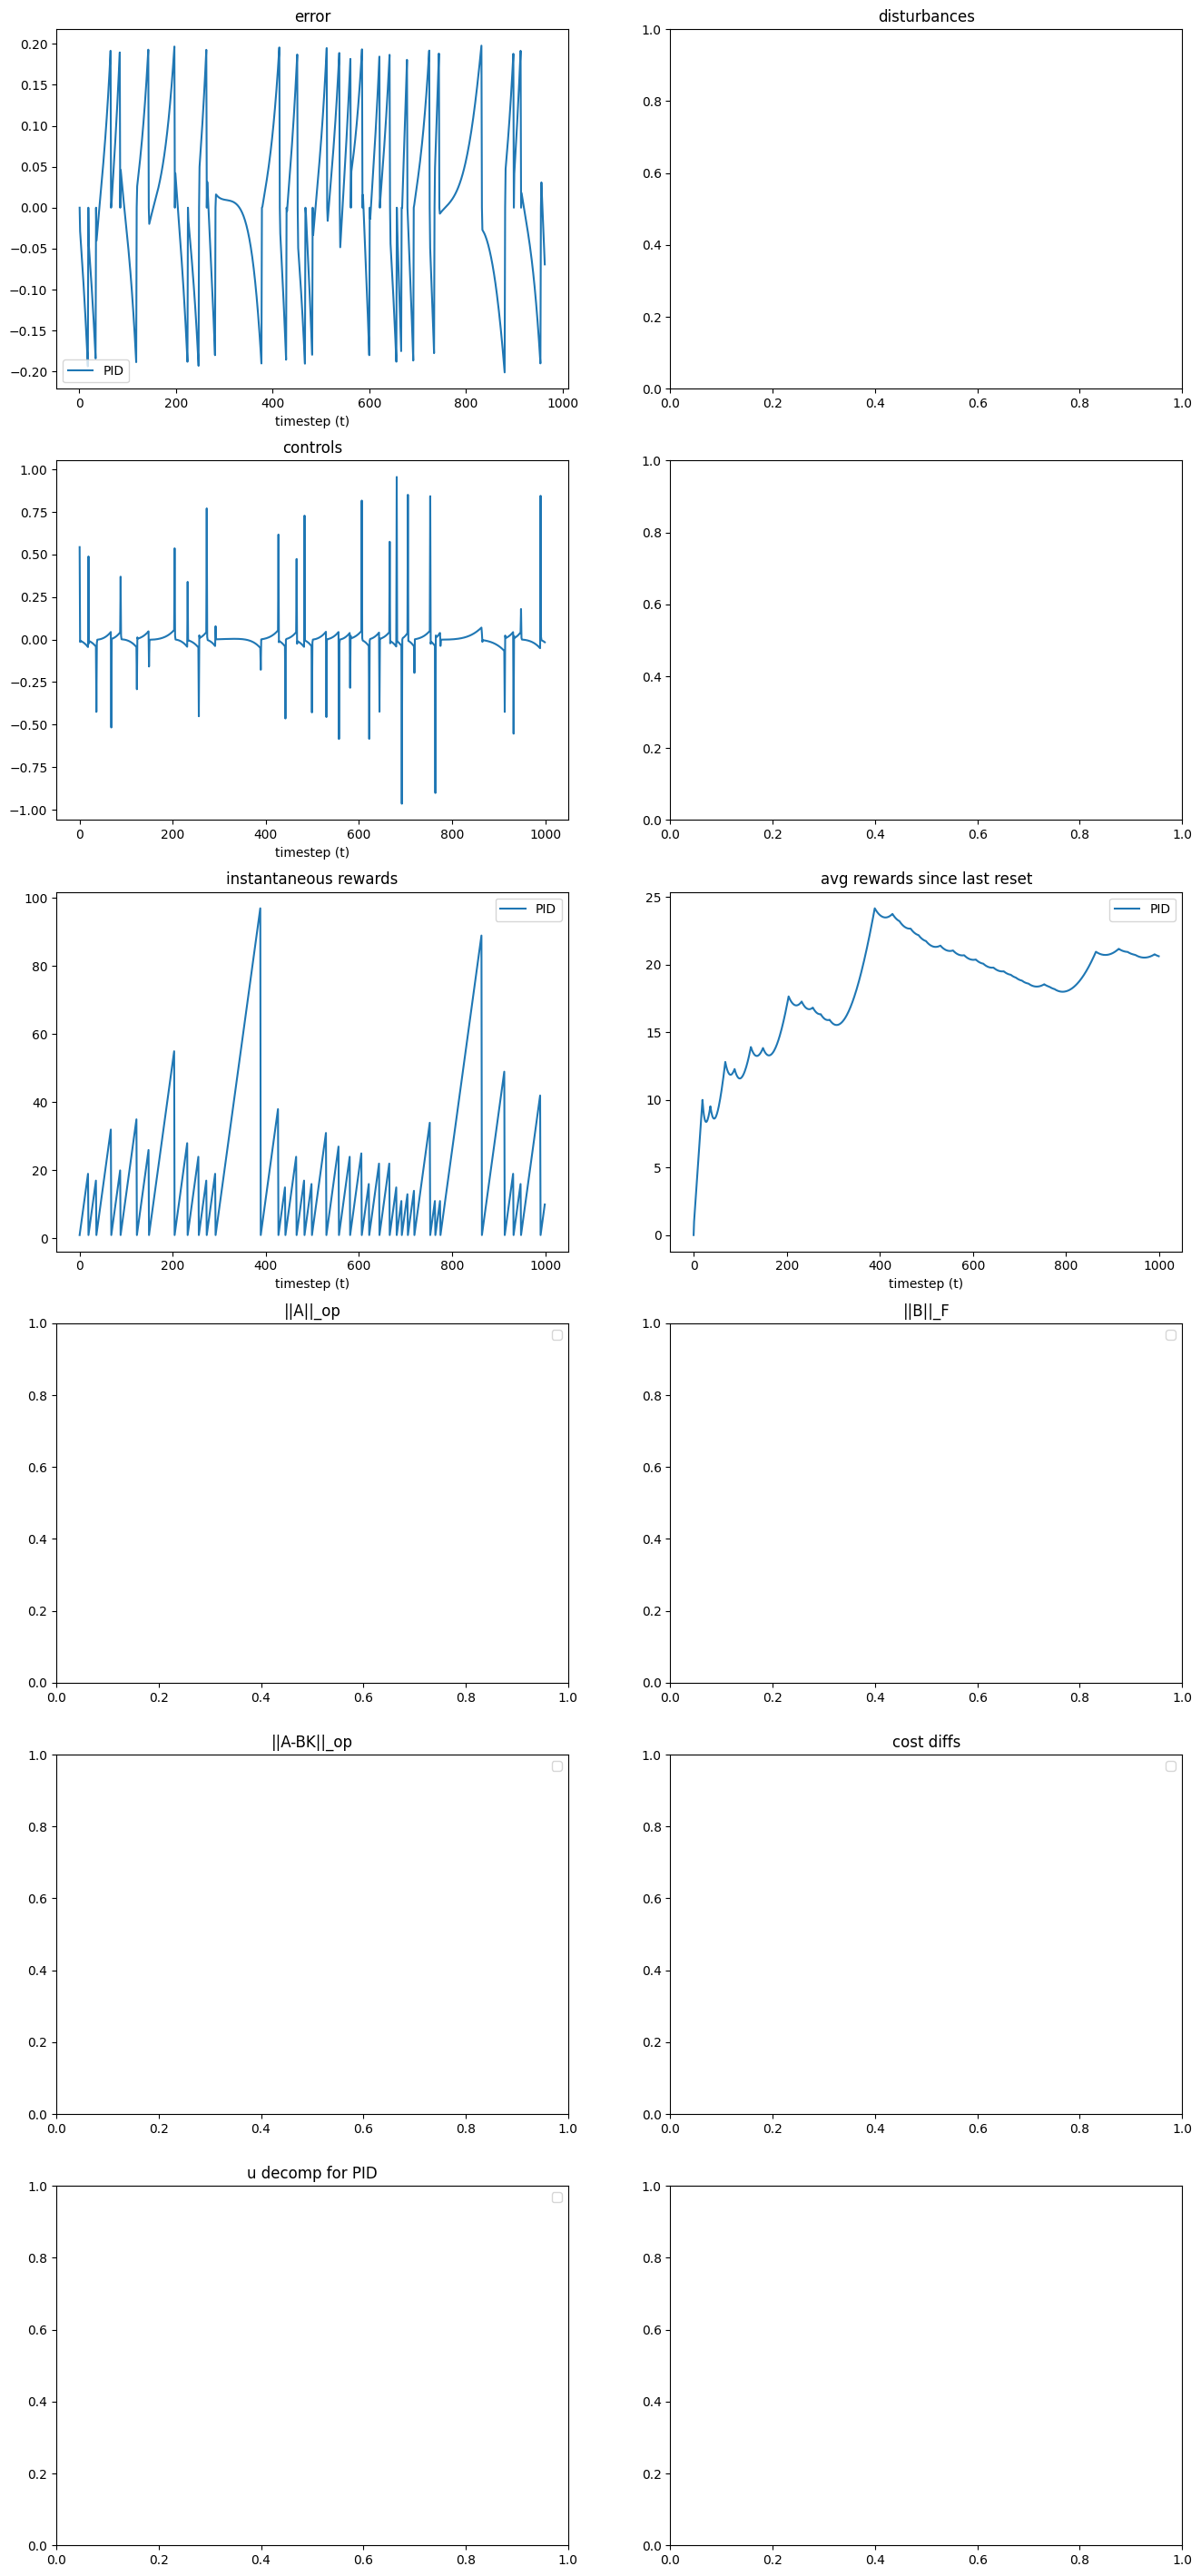

In [79]:
e = Experiment('PID')
e.stats = {'PID': p.stats}
plot_pid(e)